# Notebook: Analysis of HMM Regression Surrogate Pipeline
**Objective:**  
1. Load pre-computed black-box observation sequences.
2. Train the full `HMMRegressionSurrogate` pipeline: 
   a. Fit the HMM component. 
   b. Extract features using HMM outputs. 
   c. Fit regression models (for next-step probability and prediction intervals). 
3. Analyze the HMM component (states, transitions) - similar to the basic HMM notebook. 
4. Analyze the Regression component (validation metrics, feature importance). 
5. Visualize predictions on test reviews, showing: 
   a. True black-box probabilities. 
   b. Decoded HMM states. 
   c. Regression model's prediction for P(TARGET_SENTIMENT) at the next step. 
   d. Prediction intervals from the regression model."

In [4]:
import sys  
import os  
import numpy as np  
import matplotlib.pyplot as plt  
import pickle  
  
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)  
  
from src.config import (  
    LOG_FILE_PATH, TARGET_SENTIMENT,   
    NUM_TEST_SAMPLES, MAX_TOKENS, MODEL_NAME, DEVICE,   
    NUM_HMM_STATES, HMM_N_ITER, HMM_TOL, HMM_COV_TYPE,   
    PROB_THRESHOLDS  
)  
from src.data_utils import load_imdb_data, preprocess_data_for_inference_logging  
from src.black_box_model import BlackBoxSentimentClassifier   , log_inference_trajectories
from src.hmm_regression_surrogate import HMMRegressionSurrogate  
from src.visualization_utils import plot_hmm_transition_matrix, plot_avg_probabilities_per_state 
  
%matplotlib inline  
  
PIPELINE_MODEL_SAVE_PREFIX = "models/hmm_reg_pipeline_imdb_bigMLP" 

In [5]:
try:  
    loaded_data = np.load(LOG_FILE_PATH)  
    all_observation_sequences = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]  
    print(f"Loaded {len(all_observation_sequences)} total observation trajectories from {LOG_FILE_PATH}.")  
    if all_observation_sequences:  
        print(f"Example trajectory 0 shape: {all_observation_sequences[0].shape}")  
except FileNotFoundError:  
    print(f"Error: Log file {LOG_FILE_PATH} not found. Please run Notebook 01_Inference_Logging.ipynb first.")  
    all_observation_sequences = []


Loaded 25000 total observation trajectories from /home/gamerio/Documents/pml/PMLproject/notebooks/data/imbd_inference_logs25k.npz.
Example trajectory 0 shape: (512, 2)


In [6]:
pipeline_surrogate = None  
TRAIN_PIPELINE = True 
  
if TRAIN_PIPELINE:  
    if all_observation_sequences and len(all_observation_sequences) > 50: 
        pipeline_surrogate = HMMRegressionSurrogate(  
            n_states=NUM_HMM_STATES,   
            n_iter=HMM_N_ITER, 
            tol=HMM_TOL,  
            covariance_type=HMM_COV_TYPE, 
            random_state=2,  
            regression_method='mlp',   
            min_hmm_covar=1e-3,   
            
            use_feature_scaling=True,  
            use_pca_features=False, 
            n_pca_components=3 
        )  
          
        # The train_full_pipeline method handles HMM training, feature extraction,   
        # regression training, and internal validation splits for regression.  
        # It uses a split of `all_observation_sequences` for HMM training vs. regression data generation.  
        pipeline_surrogate.train_full_pipeline(  
            all_observation_sequences,   
            validation_split_ratio=0.25, # 25% of total for regression data generation + reg validation  
            regression_train_split_ratio=0.8 # Within the 25%, 80% for reg training, 20% for reg validation  
        )  
  
        pipeline_surrogate.save_pipeline(PIPELINE_MODEL_SAVE_PREFIX)  
    else:  
        print("Skipping pipeline training: not enough observation sequences loaded or TRAIN_PIPELINE is False.")  
else:  
    print(f"Attempting to load pre-trained pipeline from prefix {PIPELINE_MODEL_SAVE_PREFIX}")  
    try:  
        pipeline_surrogate = HMMRegressionSurrogate.load_pipeline(PIPELINE_MODEL_SAVE_PREFIX)  
        if not pipeline_surrogate.is_hmm_trained or not pipeline_surrogate.is_regression_trained:  
            print("Loaded pipeline is not fully trained. Check saved model.")  
            pipeline_surrogate = None  
    except FileNotFoundError:  
        print(f"Error: Pre-trained pipeline not found at {PIPELINE_MODEL_SAVE_PREFIX}.pkl. Please train one first.")  
        pipeline_surrogate = None

=== Training Full HMM Regression Pipeline ===

Step 1: Fitting HMM Component...

--- Applying HMM Robustness Enhancements (Pre-Fit) ---

Training HMM with 3 states (cov_type='diag') on 18750 sequences.
Using min_covar for hmmlearn fit: 0.001


         1 -6821792.42857704             +nan
         2  901283.79633566 +7723076.22491269
         3 8661763.16126175 +7760479.36492610
         4 12582720.85806072 +3920957.69679896
         5 14567544.11901846 +1984823.26095775
         6 15987669.30011673 +1420125.18109827
         7 16917456.07698945 +929786.77687272
         8 17539560.13788962 +622104.06090017
         9 17956584.65423844 +417024.51634882
        10 18239292.02399382 +282707.36975538
        11 18431186.44365500 +191894.41966118
        12 18562395.26482831 +131208.82117331
        13 18651808.61282875  +89413.34800044
        14 18713718.97154531  +61910.35871656
        15 18756069.74546987  +42350.77392456
        16 18784554.96581876  +28485.22034889
        17 18804048.62260638  +19493.65678762
        18 18817505.74252542  +13457.11991905
        19 18826969.07316930   +9463.33064387
        20 18833543.62963707   +6574.55646778
        21 18838200.06203854   +4656.43240146
        22 18841565.24842238   


--- Applying HMM Robustness Enhancements (Post-Fit) ---
HMM not trained or covars not available for post-processing.

HMM training complete with robustness enhancements.
--- Enhanced HMM Parameters ---
Initial state probabilities (startprob_):
 [0. 0. 1.]

Transition matrix (transmat_):
 [[9.94716244e-01 4.77248794e-06 5.27898347e-03]
 [1.10333514e-04 9.92909579e-01 6.98008758e-03]
 [8.39994423e-03 1.00544879e-02 9.81545568e-01]]

Emission probabilities (means_ for GaussianHMM):
 [[0.9866488  0.0133512 ]
 [0.01662439 0.98337561]
 [0.49427885 0.50572115]]

Emission covariances (covars_ for GaussianHMM):
 [[[9.39565973e-05 0.00000000e+00]
  [0.00000000e+00 9.39566012e-05]]

 [[1.49112532e-04 0.00000000e+00]
  [0.00000000e+00 1.49112506e-04]]

 [[1.09592074e-01 0.00000000e+00]
  [0.00000000e+00 1.09592074e-01]]]
Covariance floor applied: 0.001

--- Robustness Metrics ---
Minimum transition probability: 0.000005
Maximum transition probability: 0.994716
Minimum start probability: 0.000000


Extracting regression features: 100%|██████████| 6250/6250 [00:22<00:00, 276.73it/s]


Fitting and applying feature scaler...
Regression feature split: 1352554 for training, 338139 for validation.

Step 4: Fitting Regression Components...
Fitting regression models on 1352554 processed training samples.
Fitting probability regressor...
Regression model(s) fitting complete.

--- Regression Validation Results ---
  Target Probability Prediction - MSE: 0.0388, MAE: 0.1136
     Predicted Probs Range: [0.018-0.996], True Probs Range: [0.003-0.996]

Step 5: Analyzing Feature Importance...
Feature importance for MLP often requires permutation_importance (more intensive).

=== Pipeline Training Complete ===
Full HMM Regression Pipeline saved to models/hmm_reg_pipeline_imdb_bigMLP.pkl


--- Analyzing HMM Component from Pipeline ---

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 2163051, Avg. P(Class 1) = 0.013
State 1: Occurrences = 2198067, Avg. P(Class 1) = 0.983
State 2: Occurrences = 2521468, Avg. P(Class 1) = 0.507

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.013)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.507)
  HMM State 1: ~Leaning Positive/High Confidence (Avg. P(Class 1) = 0.983)


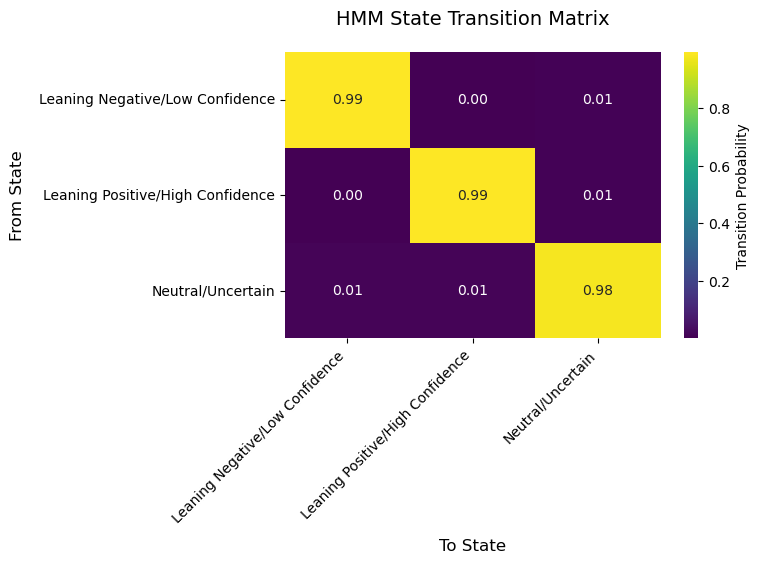

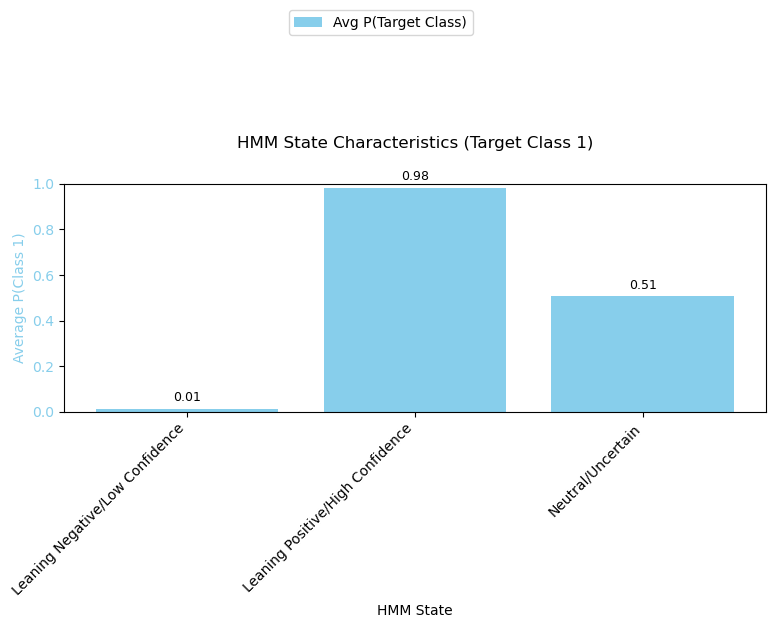

In [7]:
hmm_state_analysis_results_pipeline = None  
if pipeline_surrogate and pipeline_surrogate.is_hmm_trained:  
    print("--- Analyzing HMM Component from Pipeline ---")  
    
  
    analysis_sequences = all_observation_sequences[: len(all_observation_sequences)] 
      
    decoded_hmm_states_for_analysis = [  
        pipeline_surrogate.decode_hmm_sequence(traj)   
        for traj in analysis_sequences if traj.shape[0] > 0  
    ]  
      
    valid_obs_for_analysis = [  
        traj for traj, states in zip(analysis_sequences, decoded_hmm_states_for_analysis) if states.size > 0  
    ]  
    valid_decoded_states_for_analysis = [states for states in decoded_hmm_states_for_analysis if states.size > 0]  
  
    if valid_obs_for_analysis and valid_decoded_states_for_analysis:  
        hmm_state_analysis_results_pipeline = pipeline_surrogate.analyze_hmm_states(  
            valid_obs_for_analysis,   
            valid_decoded_states_for_analysis,   
            target_class_idx=TARGET_SENTIMENT  
        )  
      
        if hasattr(pipeline_surrogate, 'hmm_model'):   
             plot_hmm_transition_matrix(pipeline_surrogate.hmm_model, state_names=hmm_state_analysis_results_pipeline.get('state_names'))  
             plot_avg_probabilities_per_state(hmm_state_analysis_results_pipeline, target_class_idx=TARGET_SENTIMENT)  
    else:  
        print("Could not perform HMM state analysis due to lack of valid data for analysis")  
else:  
    print("Pipeline or HMM component not trained/loaded. Skipping HMM state analysis.")

In [8]:
if pipeline_surrogate and pipeline_surrogate.is_regression_trained:
    print("--- Re-running Feature Importance Analysis for Regression Models ---")
    pipeline_surrogate.analyze_feature_importance()
else:
    print("Regression component not trained/loaded. Skipping feature importance.")
    

--- Re-running Feature Importance Analysis for Regression Models ---
Feature importance for MLP often requires permutation_importance (more intensive).


--- Visualizing Pipeline Predictions on Test Reviews ---
Model loaded successfully on cuda
loaded black box model: lvwerra/distilbert-imdb
Labels: {0: 'NEGATIVE', 1: 'POSITIVE'}


Processing data: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]



Visualizing Test Sample 1 (length 315):
Text: This cheap, grainy-filmed Italian flick is about a couple of inheritors of a manor in the Italian countryside who head up to the house to stay, and th...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 313, Avg. P(Class 1) = 0.008
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 2, Avg. P(Class 1) = 0.613

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.008)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.613)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] this cheap , grain ##y - filmed italian flick is about a couple of 
inherit ##ors of a manor in the italian countryside who head up to the house to 
stay , and then find themselves getting

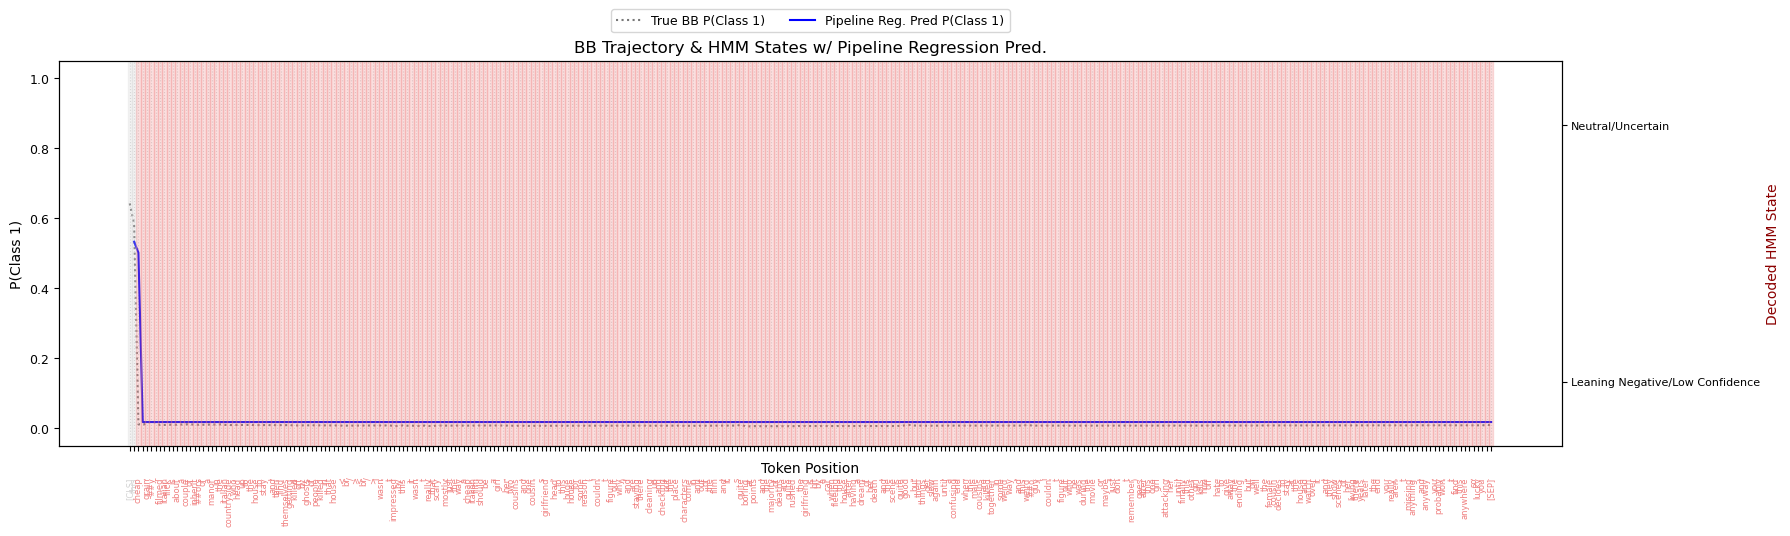


Visualizing Test Sample 2 (length 181):
Text: I first watched this movie back in the mid/late 80's, when I was a kid. We couldn't even get all the way through it. The dialog, the acting, everythin...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 134, Avg. P(Class 1) = 0.013
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 47, Avg. P(Class 1) = 0.659

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.013)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.659)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] i first watched this movie back in the mid / late 80 ' s , when i was a 
kid . we couldn ' t even get all the way through it . the dial ##og , the 
acting , everything about it was just b

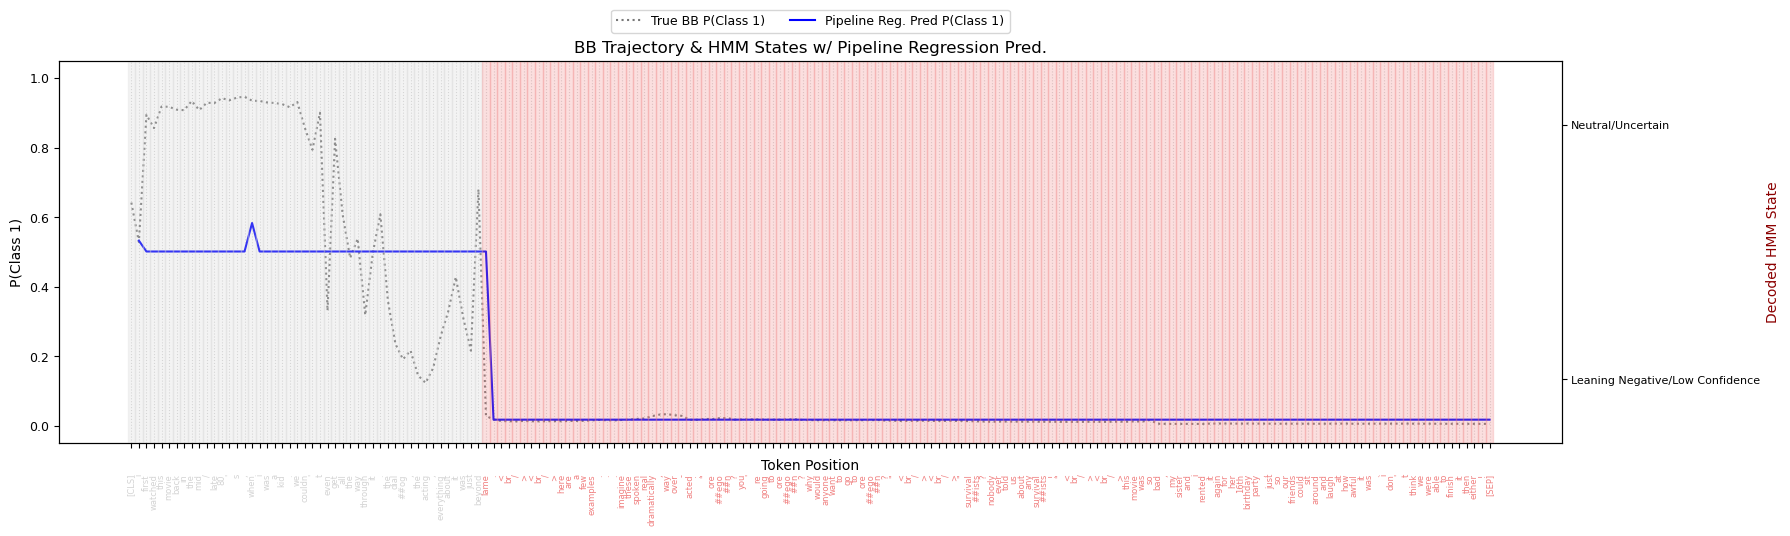


Visualizing Test Sample 3 (length 367):
Text: Ben, (Rupert Grint), is a deeply unhappy adolescent, the son of his unhappily married parents. His father, (Nicholas Farrell), is a vicar and his moth...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 0, Avg. P(Class 1) = 0.000
State 1: Occurrences = 16, Avg. P(Class 1) = 0.954
State 2: Occurrences = 351, Avg. P(Class 1) = 0.693

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.693)
  HMM State 1: ~Leaning Positive/High Confidence (Avg. P(Class 1) = 0.954)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 1: Leaning Positive/High Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] ben , ( rupert grin ##t ) , is a deeply unhappy adolescent , the son of 
his un ##ha ##pp ##ily married parents . his father , ( nicholas farrell ) , is 
a vicar and his mother , ( laur

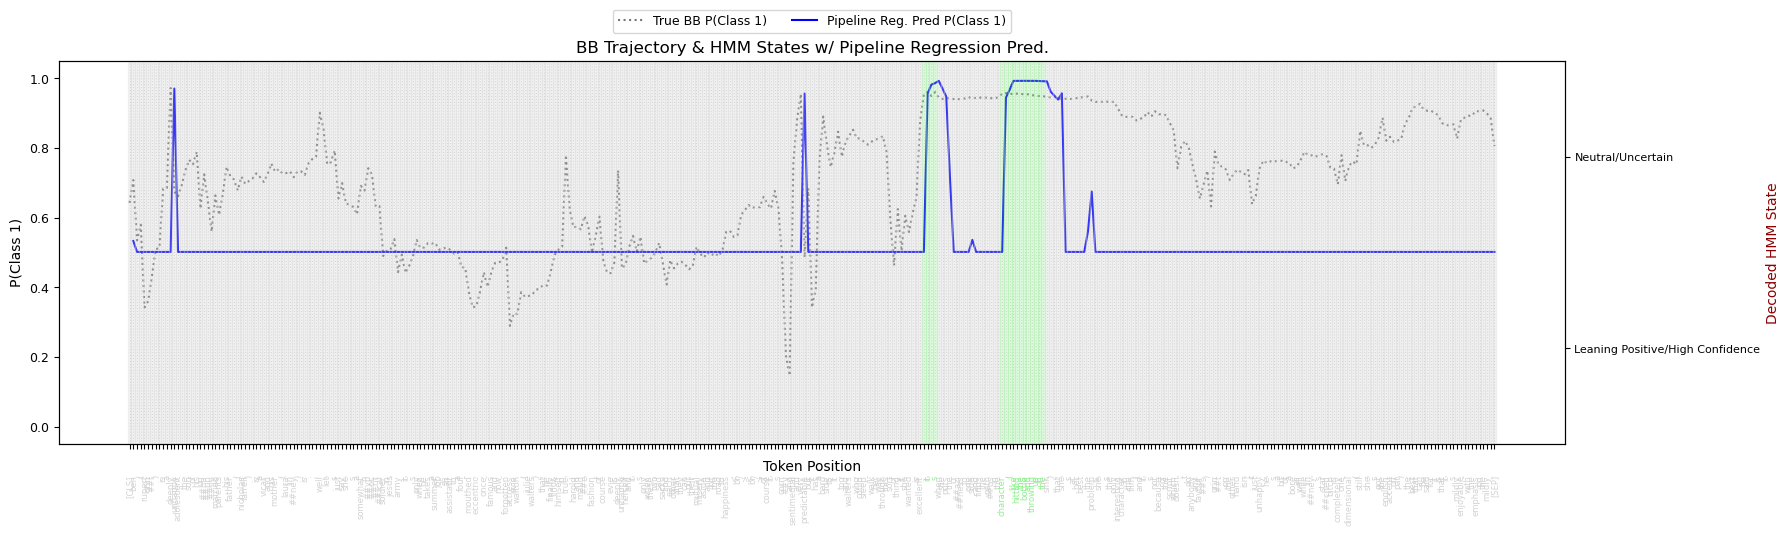


Visualizing Test Sample 4 (length 187):
Text: Technically I'am a Van Damme Fan, or I was. this movie is so bad that I hated myself for wasting those 90 minutes. Do not let the name Isaac Florentin...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 168, Avg. P(Class 1) = 0.005
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 19, Avg. P(Class 1) = 0.282

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.005)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.282)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] technically i ' am a van dam ##me fan , or i was . this movie is so bad 
that i hated myself for wasting those 90 minutes . do not let the name isaac fl 
##ore ##ntine ( und ##is ##puted 

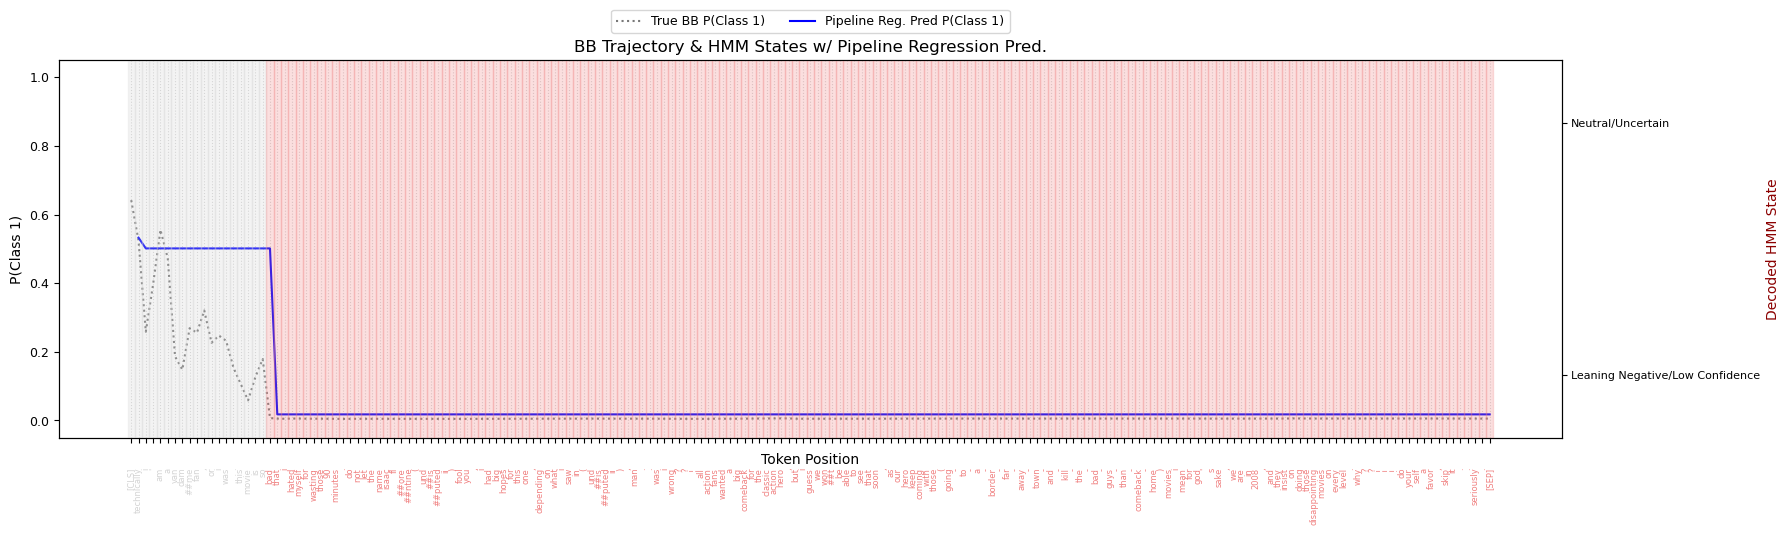


Visualizing Test Sample 5 (length 488):
Text: STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning <br /><br />Former New Orleans homicide cop Ja...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 205, Avg. P(Class 1) = 0.014
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 283, Avg. P(Class 1) = 0.592

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.014)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.592)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] star rating : * * * * * saturday night * * * * friday night * * * friday 
morning * * sunday night * monday morning < br / > < br / > former new orleans 
homicide cop jack rob ##ide ##au

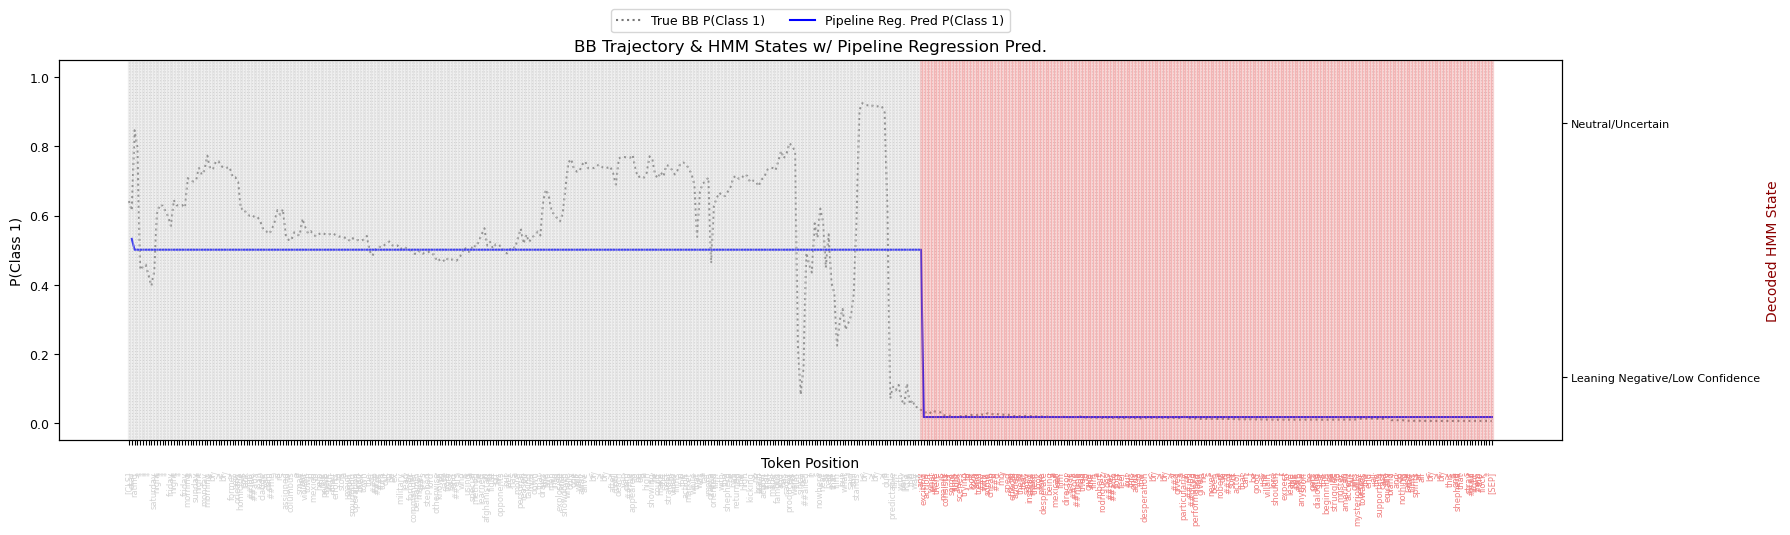


Visualizing Test Sample 6 (length 512):
Text: I saw the Mogul Video VHS of this. That's another one of those old 1980s distributors whose catalog I wish I had!<br /><br />This movie was pretty poo...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 472, Avg. P(Class 1) = 0.018
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 40, Avg. P(Class 1) = 0.365

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.018)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.365)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] i saw the mo ##gul video vhs of this . that ' s another one of those old 
1980s distributors whose catalog i wish i had ! < br / > < br / > this movie 
was pretty poor . though re ##title

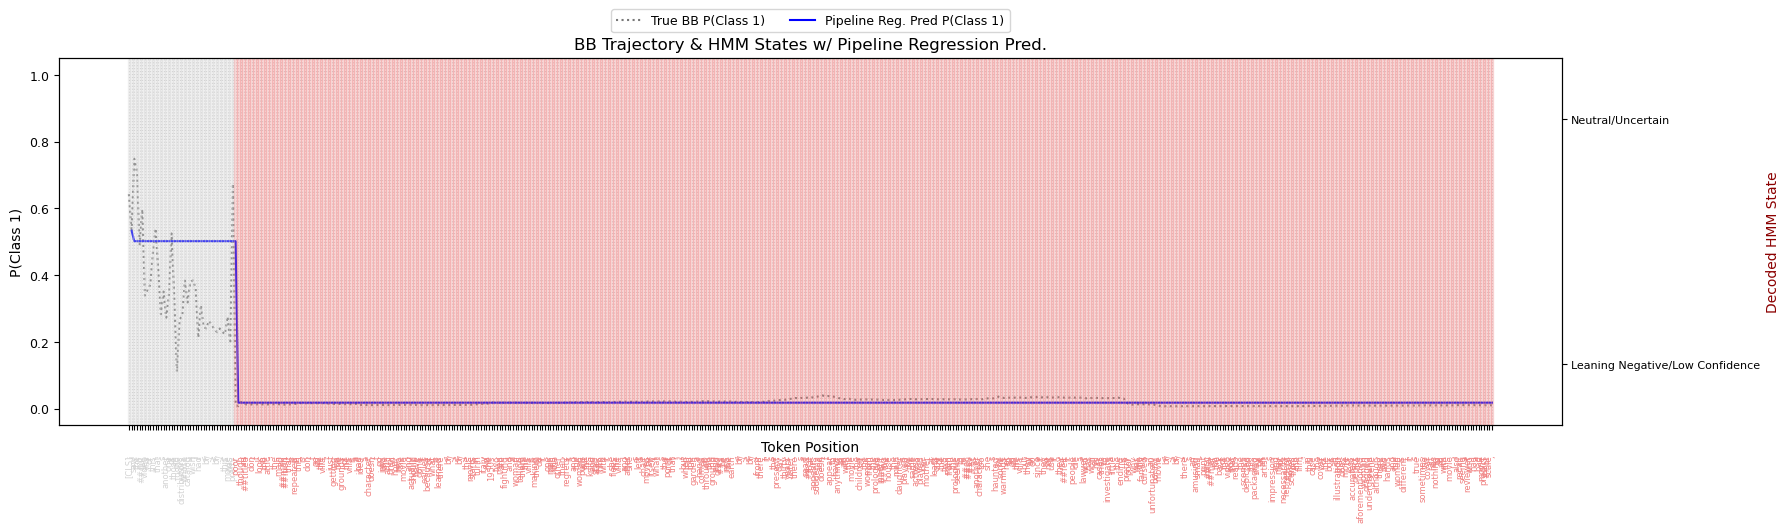


Visualizing Test Sample 7 (length 239):
Text: Now, I LOVE Italian horror films. The cheesier they are, the better. However, this is not cheesy Italian. This is week-old spaghetti sauce with rottin...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 122, Avg. P(Class 1) = 0.019
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 117, Avg. P(Class 1) = 0.459

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.019)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.459)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] now , i love italian horror films . the che ##es ##ier they are , the 
better . however , this is not che ##es ##y italian . this is week - old 
spaghetti sauce with rotting meat ##balls

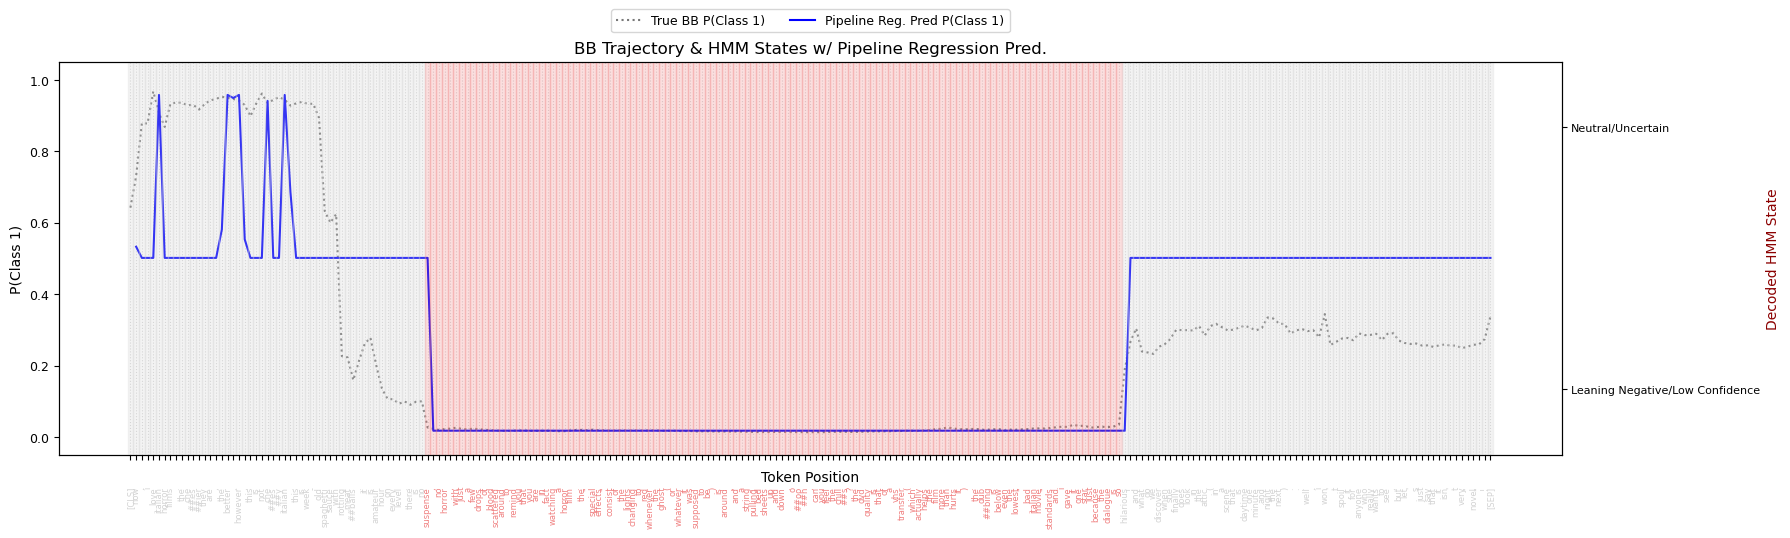


Visualizing Test Sample 8 (length 158):
Text: This flick is a waste of time.I expect from an action movie to have more than 2 explosions and some shooting.Van Damme's acting is awful. He never was...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 153, Avg. P(Class 1) = 0.004
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 5, Avg. P(Class 1) = 0.529

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.004)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.529)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] this flick is a waste of time . i expect from an action movie to have 
more than 2 explosions and some shooting . van dam ##me ' s acting is awful . 
he never was much of an actor , but he

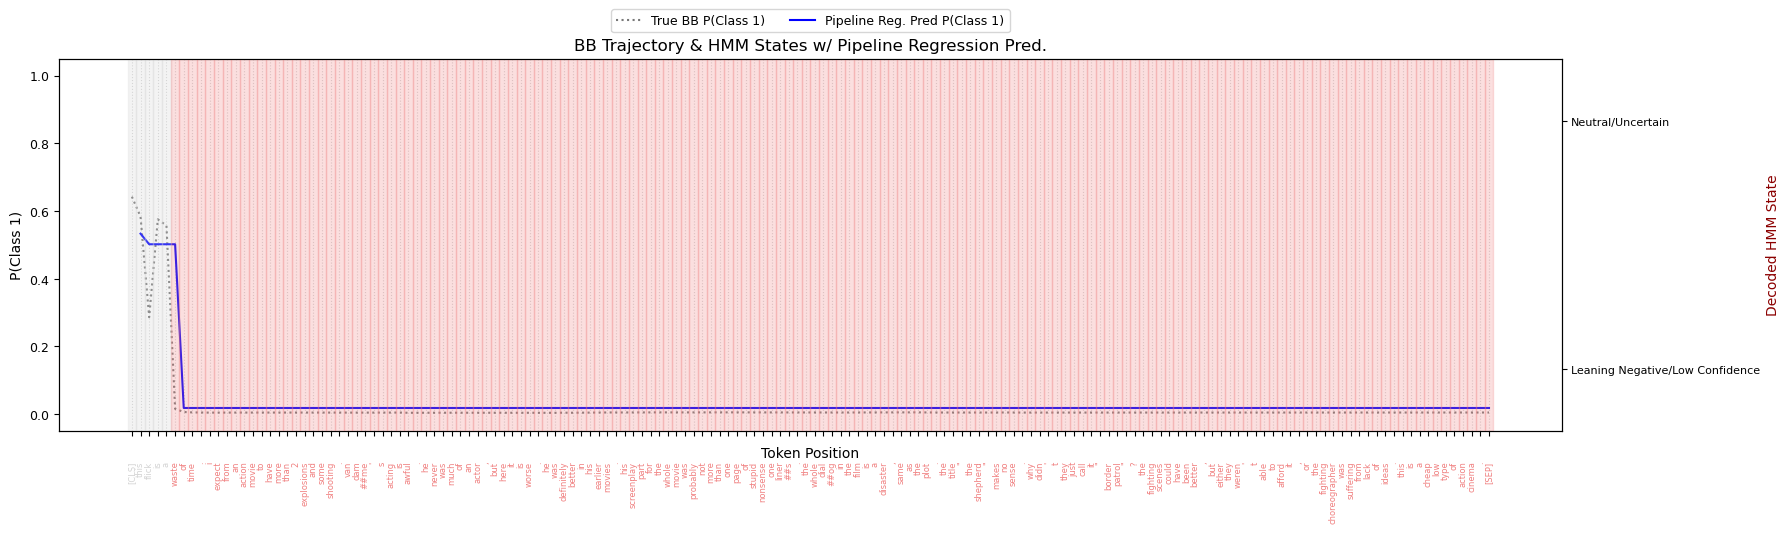


Visualizing Test Sample 9 (length 376):
Text: Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces an...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 0, Avg. P(Class 1) = 0.000
State 1: Occurrences = 187, Avg. P(Class 1) = 0.980
State 2: Occurrences = 189, Avg. P(Class 1) = 0.407

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.407)
  HMM State 1: ~Leaning Positive/High Confidence (Avg. P(Class 1) = 0.980)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 1: Leaning Positive/High Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] isaac fl ##ore ##ntine has made some of the best western martial arts 
action movies ever produced . in particular us seals 2 , cold harvest , special 
forces and und ##is ##puted 2 ar

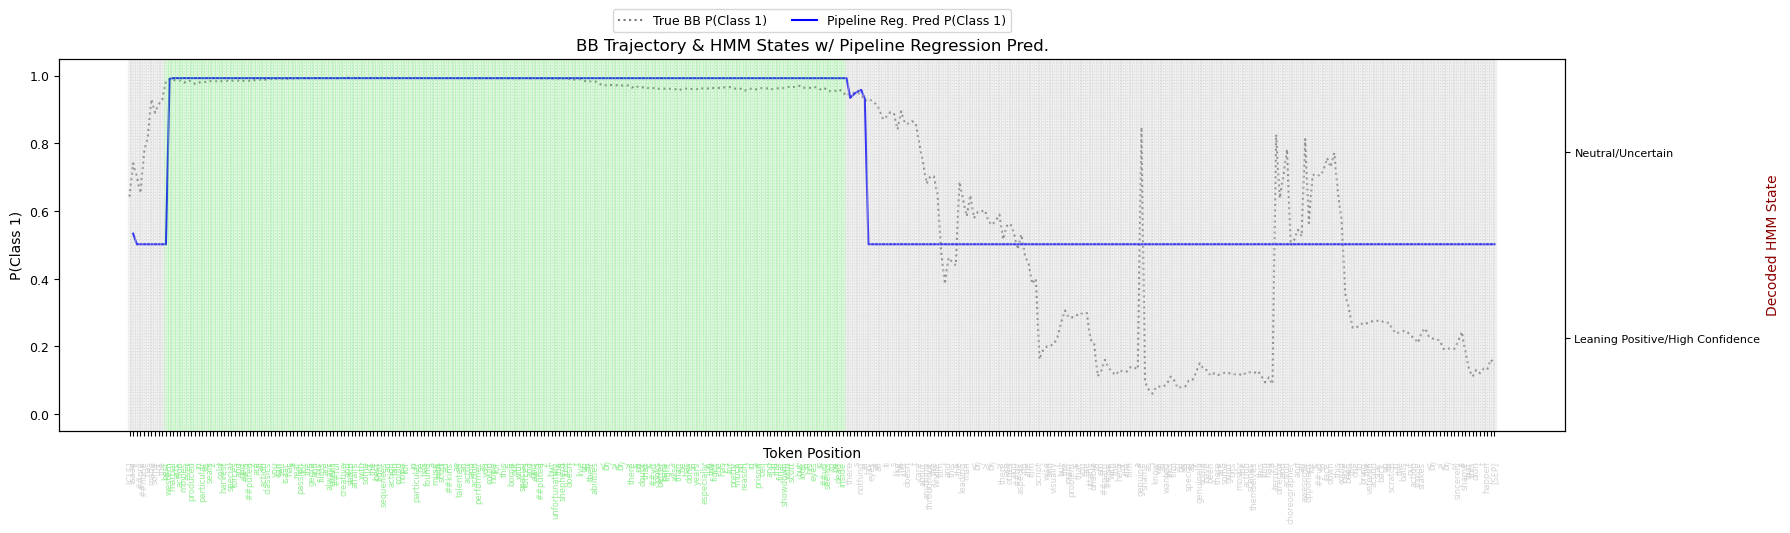


Visualizing Test Sample 10 (length 287):
Text: Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Dam...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 4, Avg. P(Class 1) = 0.032
State 1: Occurrences = 96, Avg. P(Class 1) = 0.973
State 2: Occurrences = 187, Avg. P(Class 1) = 0.519

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.032)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.519)
  HMM State 1: ~Leaning Positive/High Confidence (Avg. P(Class 1) = 0.973)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 1: Leaning Positive/High Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] worth the entertainment value of a rental , especially if you like action 
movies . this one features the usual car chases , fights with the 

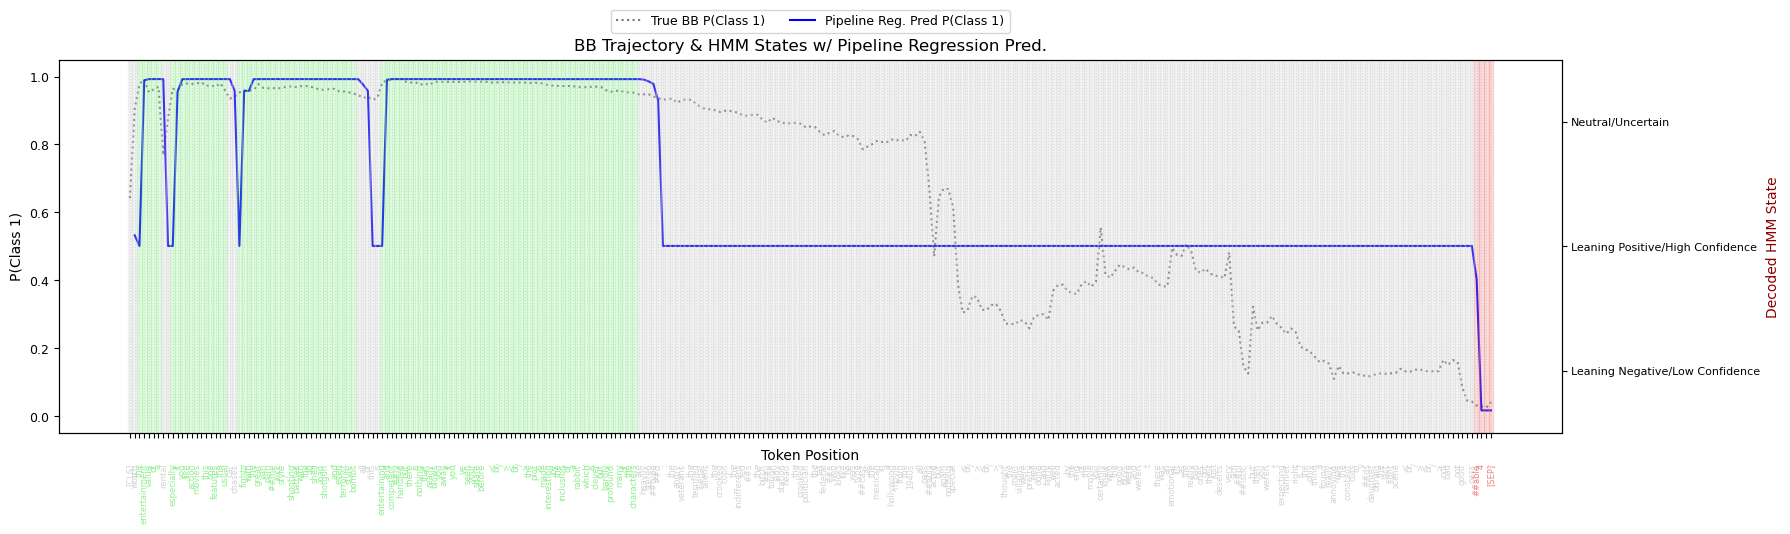


Visualizing Test Sample 11 (length 152):
Text: its a totally average film with a few semi-alright action sequences that make the plot seem a little better and remind the viewer of the classic van d...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 111, Avg. P(Class 1) = 0.017
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 41, Avg. P(Class 1) = 0.470

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.017)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.470)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] its a totally average film with a few semi - alright action sequences 
that make the plot seem a little better and remind the viewer of the classic 
van dam films . parts of the plot don

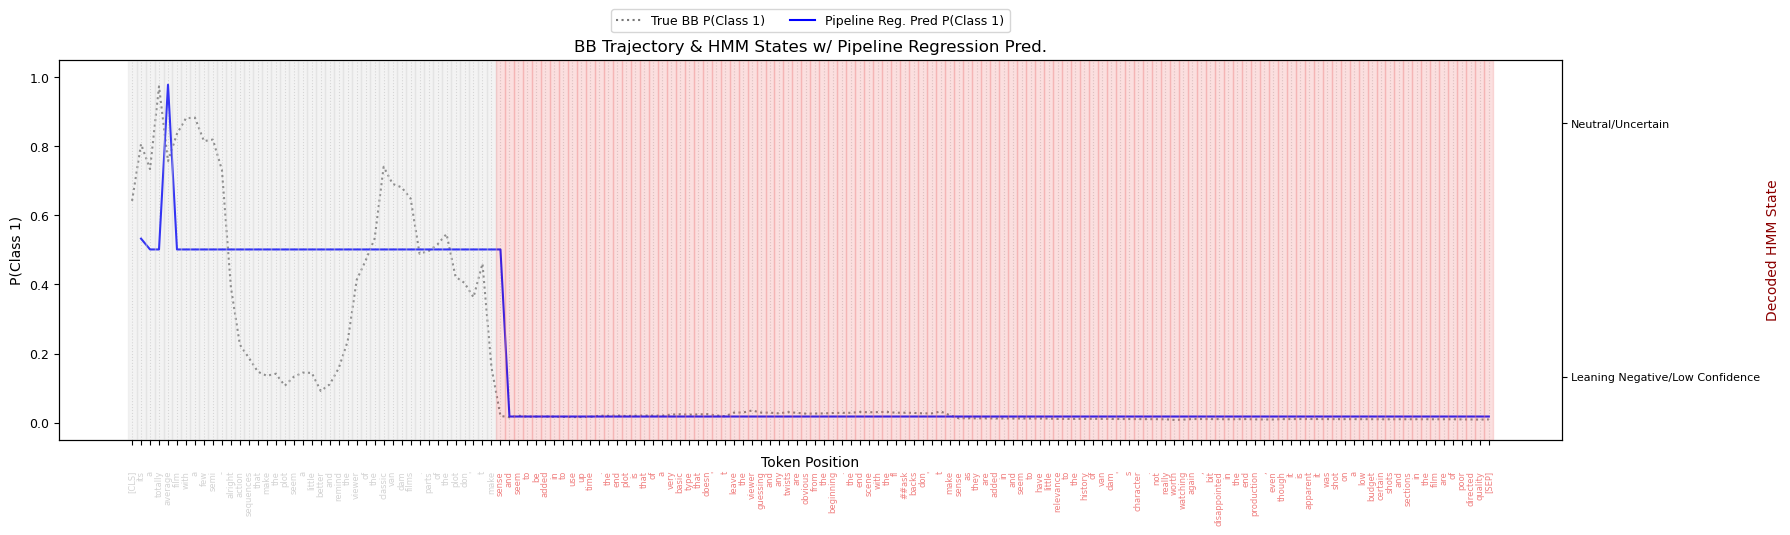


Visualizing Test Sample 12 (length 235):
Text: Blind Date (Columbia Pictures, 1934), was a decent film, but I have a few issues with this film. First of all, I don't fault the actors in this film a...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 65, Avg. P(Class 1) = 0.037
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 170, Avg. P(Class 1) = 0.128

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.037)
  HMM State 2: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.128)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Leaning Negative/Low Confidence

Review text:
[CLS] blind date ( columbia pictures , 1934 ) , was a decent film , but i have 
a few issues with this film . first of all , i don ' t fault the actors in this 
fil

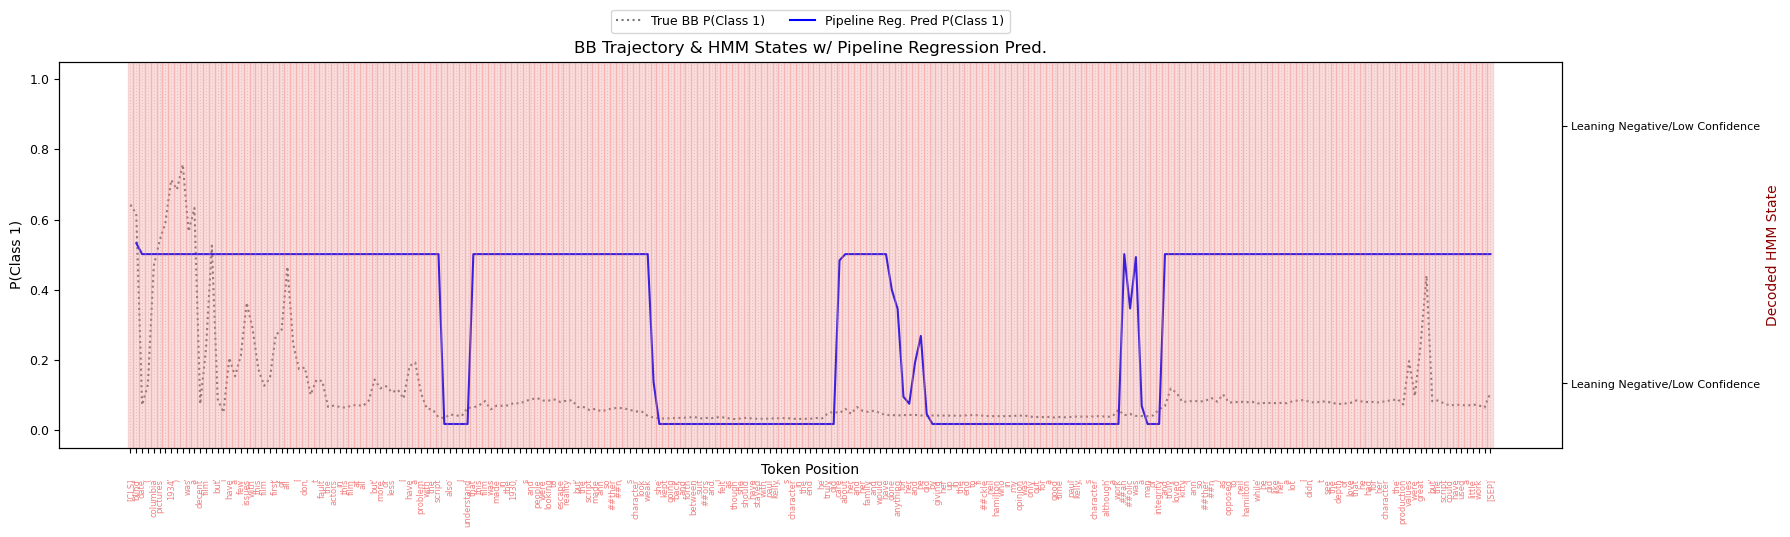


Visualizing Test Sample 13 (length 186):
Text: I just finished watching this movie and am disappointed to say that I didn't enjoy it a bit. It is so slow Slow and uninteresting. This kid from Harry...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 124, Avg. P(Class 1) = 0.020
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 62, Avg. P(Class 1) = 0.105

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.020)
  HMM State 2: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.105)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Leaning Negative/Low Confidence

Review text:
[CLS] i just finished watching this movie and am disappointed to say that i 
didn ' t enjoy it a bit . it is so slow slow and un ##int ##eres ##ting . this 
kid fro

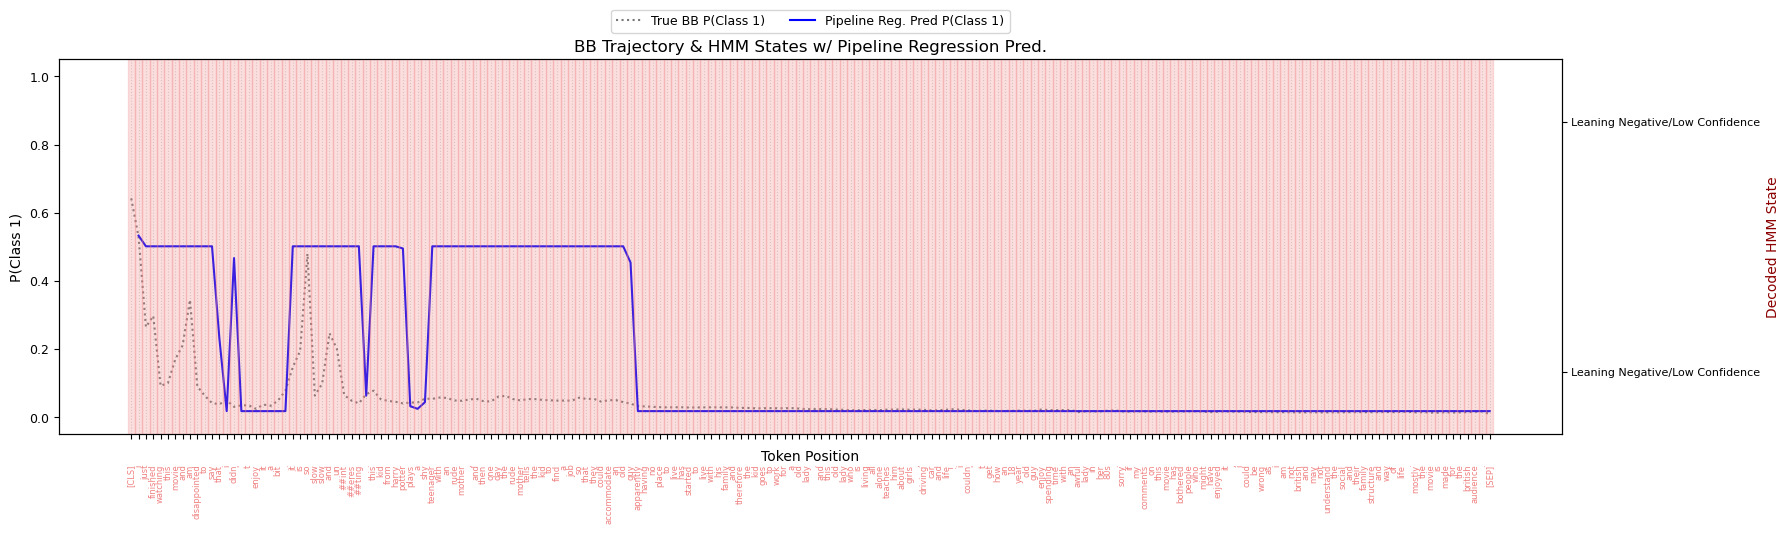


Visualizing Test Sample 14 (length 339):
Text: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 164, Avg. P(Class 1) = 0.019
State 1: Occurrences = 54, Avg. P(Class 1) = 0.971
State 2: Occurrences = 121, Avg. P(Class 1) = 0.198

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.019)
  HMM State 2: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.198)
  HMM State 1: ~Leaning Positive/High Confidence (Avg. P(Class 1) = 0.971)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 1: Leaning Positive/High Confidence
■ State 2: Leaning Negative/Low Confidence

Review text:
[CLS] i love sci - fi and am willing to put up with a lot . sci - fi movies / 
tv are usually under ##fu ##nded , und

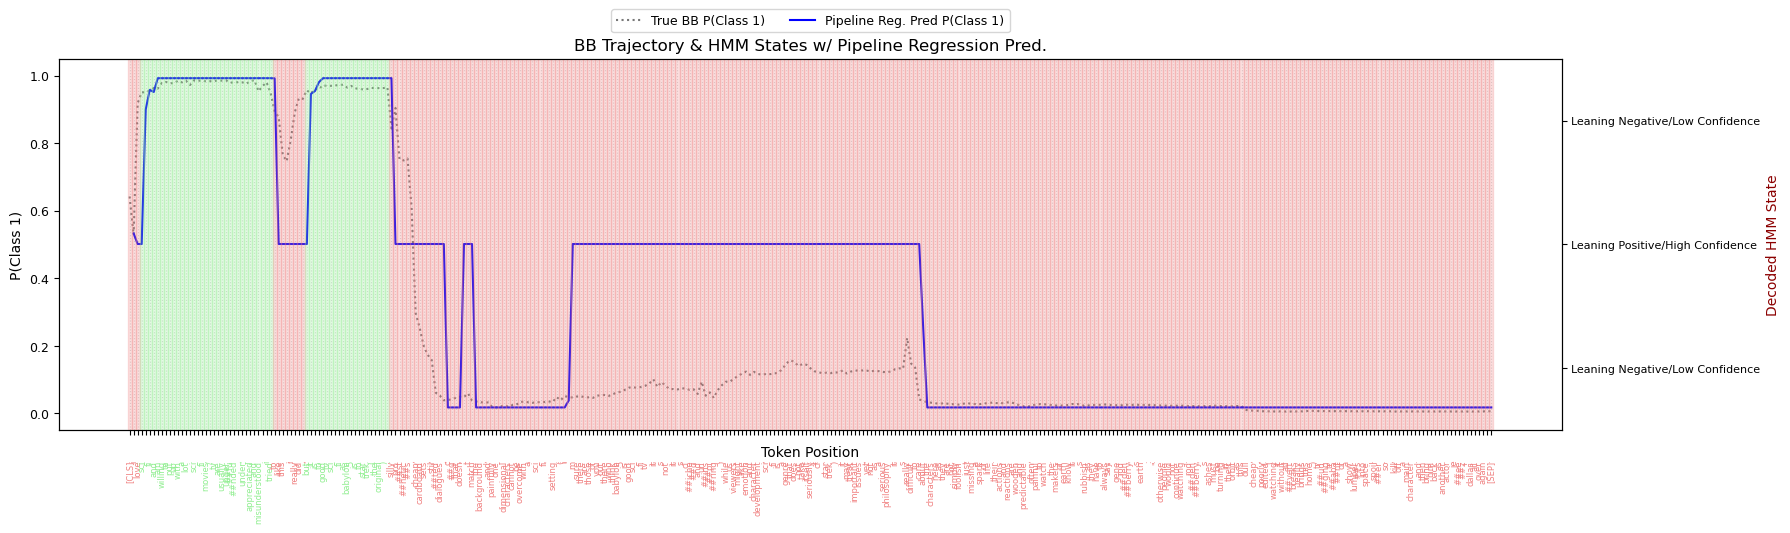


Visualizing Test Sample 15 (length 177):
Text: A group of heirs to a mysterious old mansion find out that they have to live in it as part of a clause in the will or be disinherited, but they soon f...

--- HMM State Analysis (Threshold-Based Naming) ---
State 0: Occurrences = 90, Avg. P(Class 1) = 0.020
State 1: Occurrences = 0, Avg. P(Class 1) = 0.000
State 2: Occurrences = 87, Avg. P(Class 1) = 0.674

Suggested HMM State Interpretations (based on P(Class 1)):
  HMM State 1: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.000)
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.020)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.674)

REVIEW WITH HMM STATE COLORS:

State Legend:
■ State 0: Leaning Negative/Low Confidence
■ State 2: Neutral/Uncertain

Review text:
[CLS] a group of heirs to a mysterious old mansion find out that they have to 
live in it as part of a clause in the will or be di ##sin ##her ##ited , but 
they soon find out of its history of

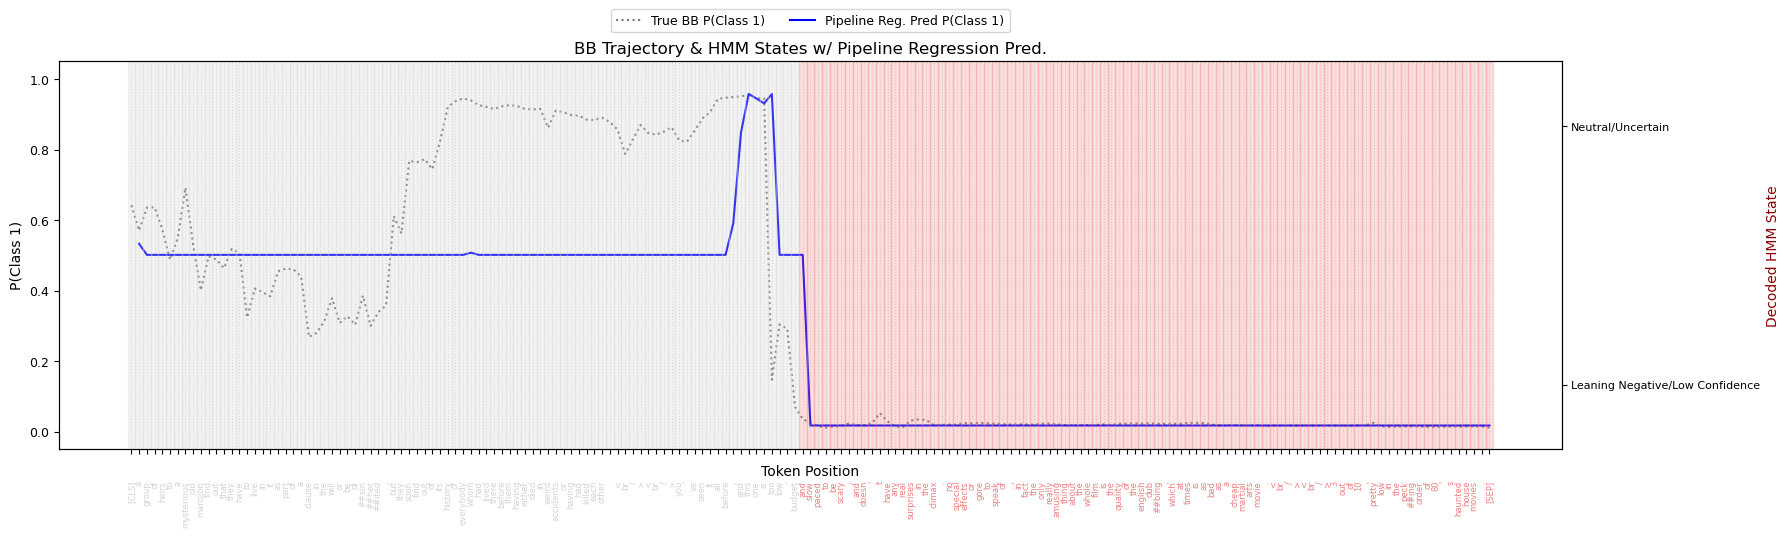


Showing first 15 samples. Set this limit higher to see more.


In [9]:
if pipeline_surrogate and pipeline_surrogate.is_hmm_trained and pipeline_surrogate.is_regression_trained and hmm_state_analysis_results_pipeline:  
    print("--- Visualizing Pipeline Predictions on Test Reviews ---")  
      
    bb_model_vis = BlackBoxSentimentClassifier(model_name=MODEL_NAME, device=DEVICE)  
    tokenizer_vis = bb_model_vis.tokenizer  
  
    imdb_test_raw_vis = load_imdb_data(split='test', num_samples=NUM_TEST_SAMPLES, shuffle=True)  
    processed_test_data_vis = preprocess_data_for_inference_logging(imdb_test_raw_vis, tokenizer_vis)  
    test_trajectories_bb_truth = log_inference_trajectories(processed_test_data_vis, bb_model_vis, max_len=MAX_TOKENS)  
      
    test_tokens_list_vis = []  
    for item in processed_test_data_vis:  
        cls_token_id = tokenizer_vis.cls_token_id  
        actual_tokens = item['tokens']  
        if cls_token_id is not None and item['input_ids'][0] == cls_token_id: 
            pass  
        elif cls_token_id is not None: 
            actual_tokens = [tokenizer_vis.cls_token] + item['tokens']  
        test_tokens_list_vis.append(actual_tokens[:MAX_TOKENS])  
  
    from src.visualization_utils import plot_state_timeline_from_surrogate
    
    for i, (true_bb_prob_traj, tokens_for_plot) in enumerate(zip(test_trajectories_bb_truth, test_tokens_list_vis)):  
        if true_bb_prob_traj.shape[0] < 1: 
            continue  
  
        print(f"\nVisualizing Test Sample {i+1} (length {len(tokens_for_plot)}):")  
        print(f"Text: {processed_test_data_vis[i]['text'][:150]}...")  
        
        
        current_tokens = tokens_for_plot[:len(true_bb_prob_traj)]

        try:
            # Call the wrapper function
            plot_state_timeline_from_surrogate(
                hmm_surrogate=pipeline_surrogate,
                tokens=current_tokens,           
                prob_trajectory=true_bb_prob_traj, 
                target_class_idx=TARGET_SENTIMENT, 
                show_predictions=True            
            )
        except Exception as e:
            print(f"  Error plotting sample {i+1}: {e}")
            import traceback
            traceback.print_exc() 
            continue
        
        if i >= 14: 
            print(f"\nShowing first {i+1} samples. Set this limit higher to see more.")
            break
            
else:  
    print("Pipeline components not fully trained/loaded or HMM state analysis missing. Skipping final test visualizations.")